In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150

In [172]:
import h5py
import numpy as np
from itertools import product
import matplotlib.pyplot as pl
from scipy.linalg import cho_factor, cho_solve
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import FastICA, RandomizedPCA

In [3]:
with h5py.File("data/k2/superstamp.h5", "r") as f:
    time = f["time"][:]
    i = np.arange(len(time))[np.isnan(time)][-1]
    time = time[i+1:]
    data = f["frames"][i+1:, :, :]
data[data == 0] = np.nan

In [4]:
m = np.isfinite(time) & np.any(np.isfinite(data), axis=(1, 2))
time = time[m]
data = data[m]

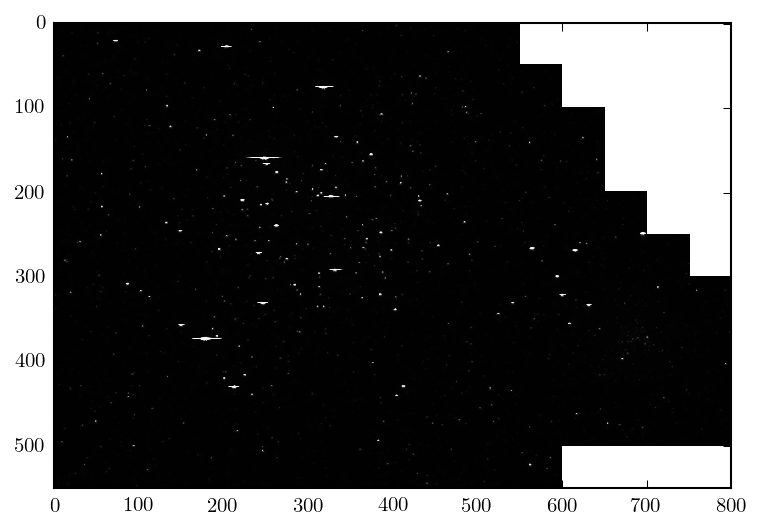

In [5]:
pl.imshow(data[0], cmap="gray", interpolation="nearest")

In [21]:
scaled = data  # / np.median(data, axis=0)[None, :, :]

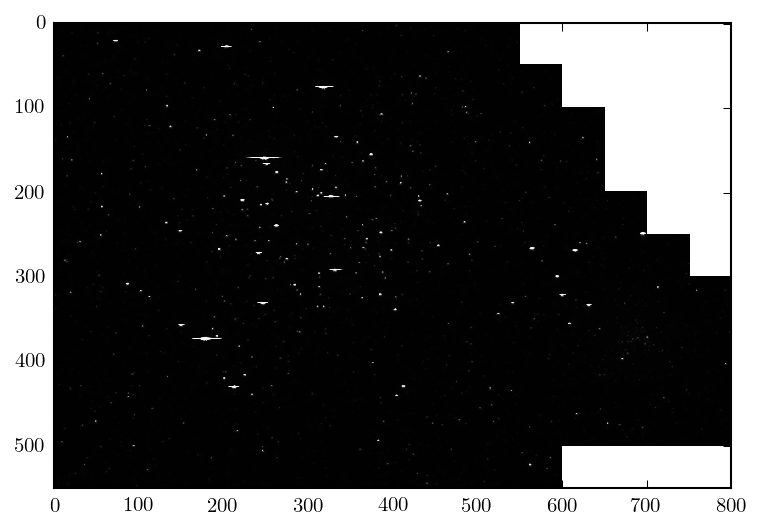

In [183]:
pl.imshow(scaled[0], cmap="gray", interpolation="nearest")

In [142]:
X, Y = np.meshgrid(range(scaled.shape[1]), range(scaled.shape[2]), indexing="ij")
m = np.any(np.isfinite(scaled), axis=0)
pred = np.zeros_like(scaled)
count = np.zeros_like(scaled[0], dtype=int)
hw = 5
ex = hw + 10

xmn, xmx = 220, 239
ymn, ymx = 300, 331

# for i, j in product(range(0, scaled.shape[1], hw+1), range(0, scaled.shape[1], hw+1)):
for i, j in product(range(xmn, xmx, hw+1), range(ymn, ymx, hw+1)):
    # Select target and predictor pixels.
    window = m & (i - hw <= X) & (X <= i + hw) & (j - hw <= Y) & (Y <= j + hw)
    r2 = (X-i)**2 + (Y-j)**2
    others = m & ((i - ex > X) | (X > i + ex) | (j - ex > Y) | (Y > j + ex)) & (r2 < 45**2)
    print(i, j, window.sum(), others.sum())

    if not (np.any(window) and np.any(others)):
        continue

    # Split predictors into train and validate.
    flag = np.random.rand(others.sum()) < 0.5
    o1 = np.array(others)
    o1[others] = flag
    o2 = np.array(others)
    o2[others] = ~flag
    
    # Compute the emperical prior.
    A = np.concatenate((scaled[:, o1], np.ones((len(scaled), 1))), axis=1)
#     ATA = np.dot(A.T, A)
#     ATA[np.diag_indices_from(ATA)] += 1e-2
#     factor = cho_factor(ATA, overwrite_a=True)
#     w0 = cho_solve(factor, np.dot(A.T, scaled[:, o2]), overwrite_b=True)
#     emp = 1. / np.sqrt(np.mean(w0**2, axis=1))  # np.sqrt(np.median(w0**2, axis=1))
    
    # Compute the prediction.
    # A = np.concatenate((A, np.diag(emp)), axis=0)
    ATA = np.dot(A.T, A)
#     print(ATA)
#     assert 0
    ATA[np.diag_indices_from(ATA)] += 1e-2
    factor = cho_factor(ATA, overwrite_a=True)
    # y = np.concatenate((scaled[:, window], np.zeros((len(emp), window.sum()))), axis=0)
    y = scaled[:, window]
    w = cho_solve(factor, np.dot(A.T, y))

    pred[:, window] += np.dot(A[:len(scaled)], w)
    count[window] += 1

220 300 121 5388
220 306 121 5388
220 312 121 5388
220 318 121 5388
220 324 121 5388
220 330 121 5388
226 300 121 5388
226 306 121 5388
226 312 121 5388
226 318 121 5388
226 324 121 5388
226 330 121 5388
232 300 121 5388
232 306 121 5388
232 312 121 5388
232 318 121 5388
232 324 121 5388
232 330 121 5388
238 300 121 5388
238 306 121 5388
238 312 121 5388
238 318 121 5388
238 324 121 5388
238 330 121 5388


In [143]:
pred[:, count > 0] /= count[count > 0]

In [144]:
d = (scaled[:, xmn:xmx, ymn:ymx] - pred[:, xmn:xmx, ymn:ymx])
np.unravel_index(np.argmax(np.abs(d)), d.shape)

(671, 5, 6)

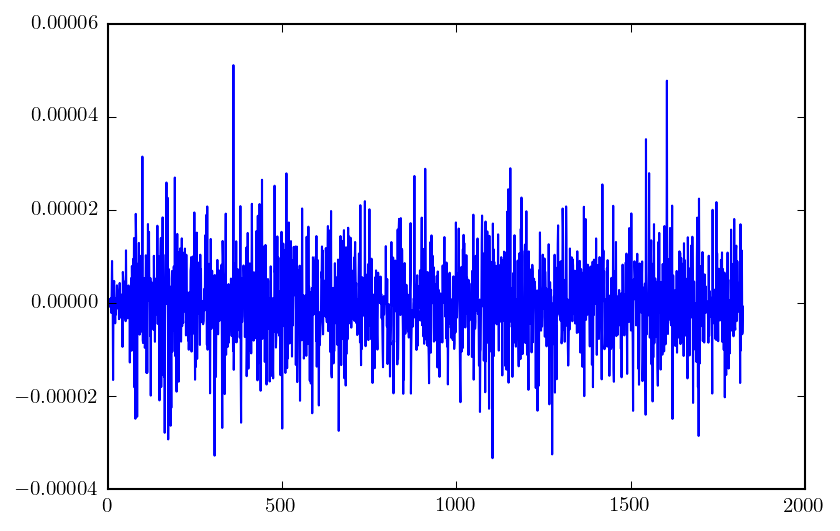

In [145]:
pl.plot(d[:, 12, 18])

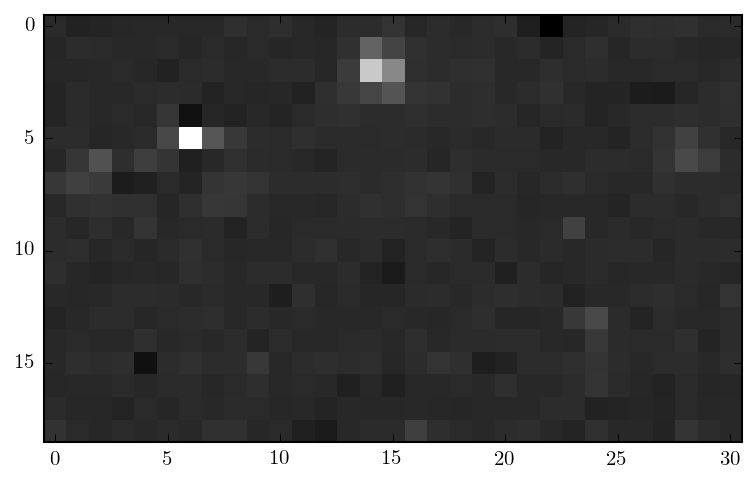

In [146]:
n = 50
pl.imshow(data[n, xmn:xmx, ymn:ymx] - pred[n, xmn:xmx, ymn:ymx], cmap="gray", interpolation="nearest")

In [147]:
d = data[:, xmn:xmx, ymn:ymx] - pred[:, xmn:xmx, ymn:ymx]
block = d.reshape((len(d), -1))
# block = block / np.median(block, axis=0) - 1

In [166]:
model = FastICA(n_components=10)
model.fit(block.T)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=10, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [167]:
n = len(model.components_)
print(n)

10


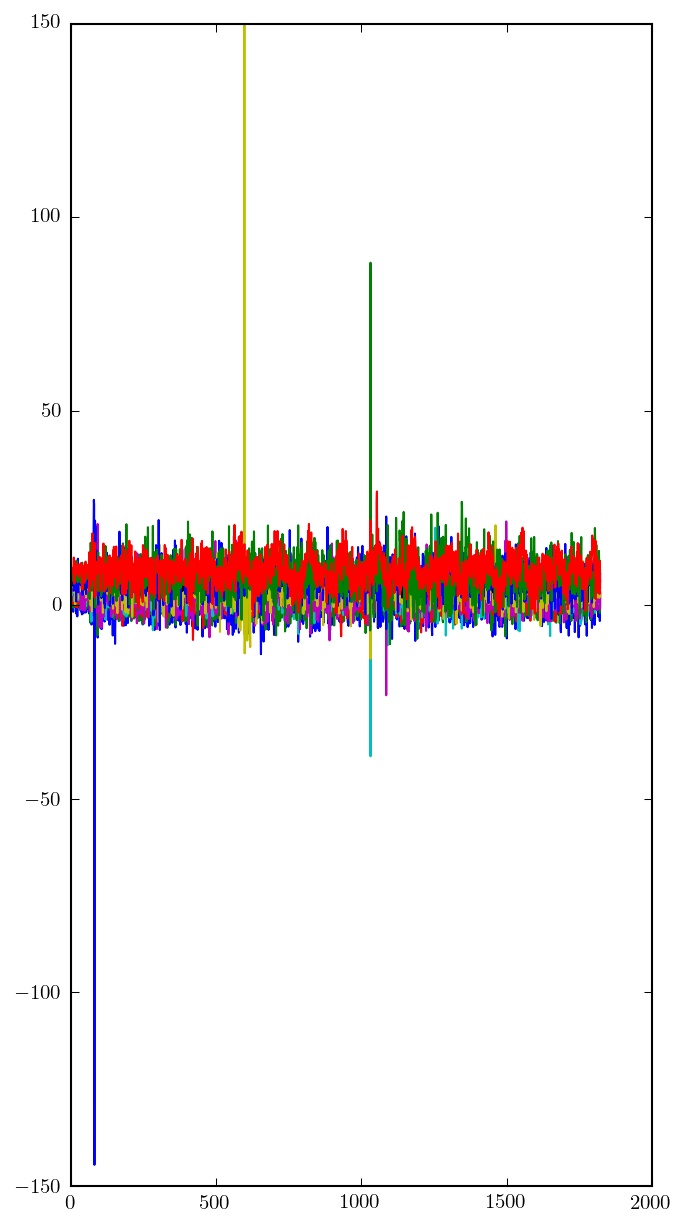

In [168]:
pl.figure(figsize=(5, 10))
pl.plot(model.components_.T + 1*np.arange(n));

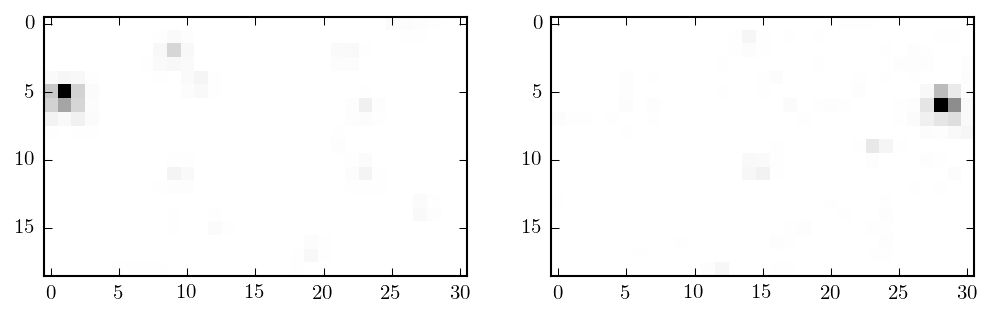

In [170]:
fig, axes = pl.subplots(1, 2, figsize=(8, 4))
v = model.components_[9]
comp = np.abs((np.dot(v, block)).reshape(d[0].shape))

axes[0].imshow(data[0, xmn:xmx, ymn:ymx], cmap="gray_r", interpolation="nearest")
axes[1].imshow(comp, cmap="gray_r", interpolation="nearest")

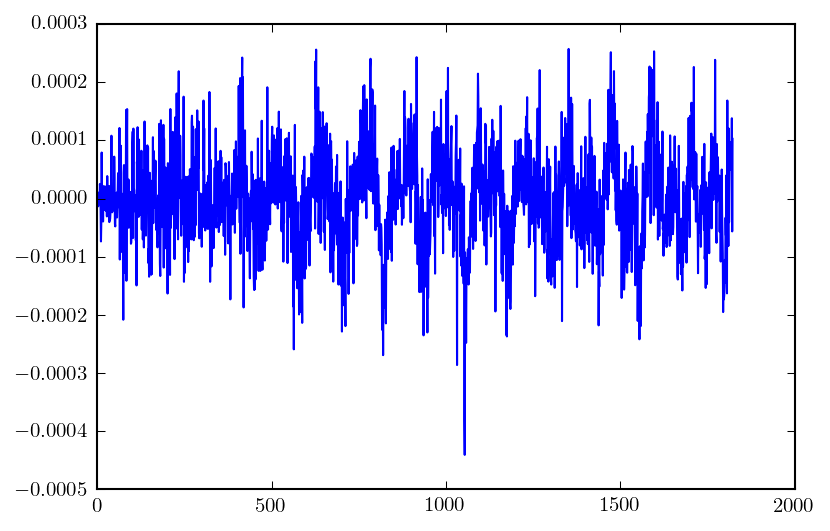

In [171]:
c = np.dot(v, block)
c /= np.sum(c)
pl.plot(np.sum(c * block, axis=1))

/Users/dfm/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/Users/dfm/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


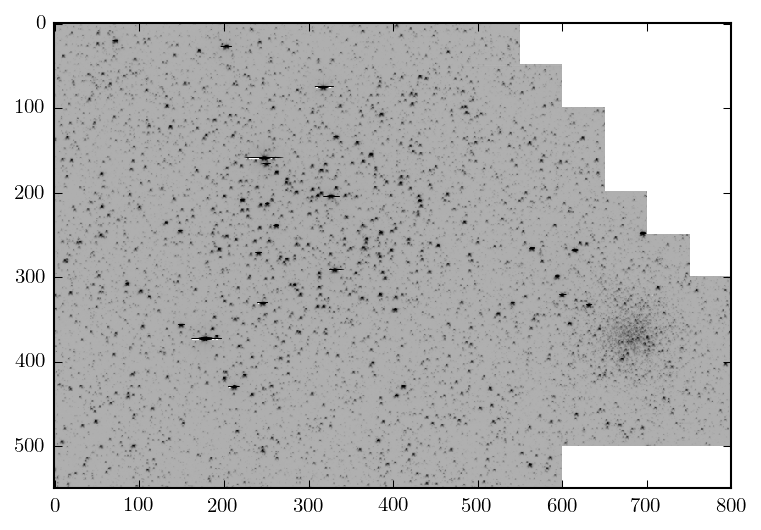

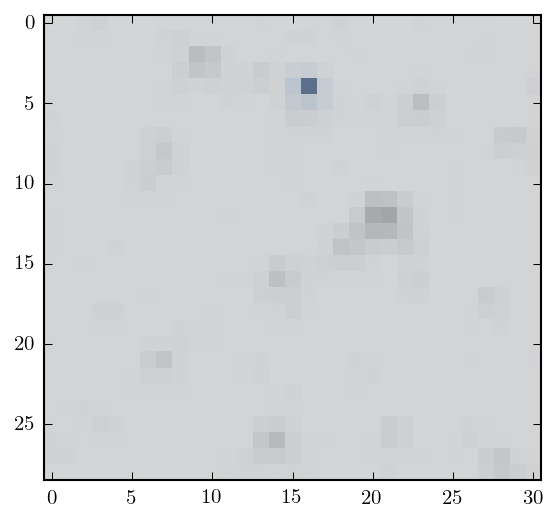

In [129]:
pl.figure()
pl.imshow(np.log(data[0]), cmap="gray_r", interpolation="nearest")
pl.figure()
pl.imshow(np.log(data[0]), cmap="gray_r", interpolation="nearest")
pl.imshow(comp, cmap="Blues", interpolation="nearest", alpha=0.5);